In [1]:
from IPython.display import Markdown
Markdown('''
## ICP (Iterative Closest Point)
O ICP é um algoritmo para alinhar duas nuvens de pontos. Ele funciona iterativamente:
1. Para cada ponto da nuvem fonte, encontra o ponto mais próximo na nuvem alvo.
2. Calcula a transformação rígida (rotação + translação) que melhor alinha os pares.
3. Aplica a transformação na nuvem fonte.
4. Repete até convergir.

Aqui, usaremos ICP para alinhar cada scan LiDAR ao anterior, acumulando as transformações para estimar a trajetória do veículo.
''')


## ICP (Iterative Closest Point)
O ICP é um algoritmo para alinhar duas nuvens de pontos. Ele funciona iterativamente:
1. Para cada ponto da nuvem fonte, encontra o ponto mais próximo na nuvem alvo.
2. Calcula a transformação rígida (rotação + translação) que melhor alinha os pares.
3. Aplica a transformação na nuvem fonte.
4. Repete até convergir.

Aqui, usaremos ICP para alinhar cada scan LiDAR ao anterior, acumulando as transformações para estimar a trajetória do veículo.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
def ler_obj_pontos(path):
    pontos = []
    with open(path, 'r') as f:
        for linha in f:
            if linha.startswith('v '):
                partes = linha.strip().split()
                x, y, z = map(float, partes[1:4])
                pontos.append([x, y, z])
    return np.array(pontos)

In [4]:
def icp(A, B, max_iter=20, tol=1e-5):
    src = np.copy(A)
    dst = np.copy(B)
    prev_error = 0
    T_total = np.eye(4)
    for i in range(max_iter):
        dists = np.linalg.norm(src[:, None, :] - dst[None, :, :], axis=2)
        indices = np.argmin(dists, axis=1)
        closest_dst = dst[indices]
        centroid_src = np.mean(src, axis=0)
        centroid_dst = np.mean(closest_dst, axis=0)
        src_centered = src - centroid_src
        dst_centered = closest_dst - centroid_dst
        H = src_centered.T @ dst_centered
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        t = centroid_dst - R @ centroid_src
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        src = (R @ src.T).T + t
        T_total = T @ T_total
        mean_error = np.mean(np.linalg.norm(src - closest_dst, axis=1))
        if np.abs(prev_error - mean_error) < tol:
            break
        prev_error = mean_error
    return T_total, mean_error

In [5]:
gt = np.load('ground_truth.npy')  # shape (30, 4, 4)

Carregando nuvens de pontos...
ERRO: /content/KITTI-Sequence\000000\000000_points.obj não encontrado
Total: 0 scans carregados


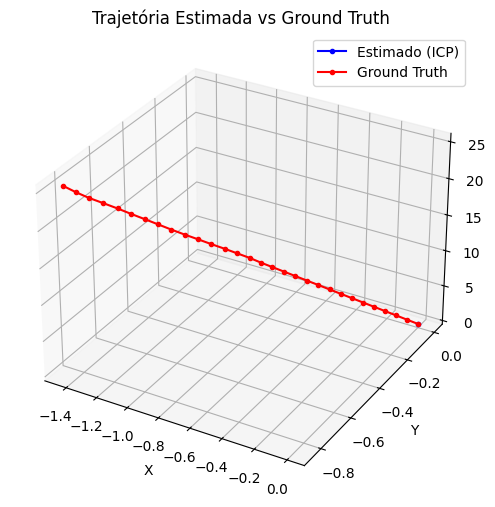

Erro médio: 12.599 metros


In [7]:
# Célula 5: Carregar nuvens de pontos (CORRIGIDO)
base_path = '/content/KITTI-Sequence'  # Ajuste conforme necessário
num_scans = 30
pontos = []

print("Carregando nuvens de pontos...")
for i in range(num_scans):
    obj_path = os.path.join(base_path, f'{i:06d}', f'{i:06d}_points.obj')
    if os.path.exists(obj_path):
        pontos.append(ler_obj_pontos(obj_path))
        print(f"Scan {i}: {len(pontos[-1])} pontos")
    else:
        print(f"ERRO: {obj_path} não encontrado")
        break

print(f"Total: {len(pontos)} scans carregados")

# Célula 6: ICP e trajetória (mesma do código anterior)
trajetoria = [np.eye(4)]
for i in range(1, len(pontos)):
    T, err = icp(pontos[i], pontos[i-1])
    T_global = trajetoria[-1] @ np.linalg.inv(T)
    trajetoria.append(T_global)
trajetoria = np.stack(trajetoria)

# Célula 7: Plot e comparação (mesma do código anterior)
def extrair_xyz(traj):
    return traj[:, :3, 3]

xyz_est = extrair_xyz(trajetoria)
xyz_gt = extrair_xyz(gt)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz_est[:,0], xyz_est[:,1], xyz_est[:,2], 'b.-', label='Estimado (ICP)')
ax.plot(xyz_gt[:,0], xyz_gt[:,1], xyz_gt[:,2], 'r.-', label='Ground Truth')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Trajetória Estimada vs Ground Truth')
ax.legend()
plt.show()

erro = np.linalg.norm(xyz_est - xyz_gt, axis=1)
print(f'Erro médio: {np.mean(erro):.3f} metros')

=== ANÁLISE DE ERRO ===
Erro médio total: 12.599 ± 7.613 metros
Erro X: 0.698 ± 0.428 metros
Erro Y: 0.418 ± 0.254 metros
Erro Z: 12.573 ± 7.596 metros
Erro máximo: 25.651 metros
Erro mínimo: 0.000 metros


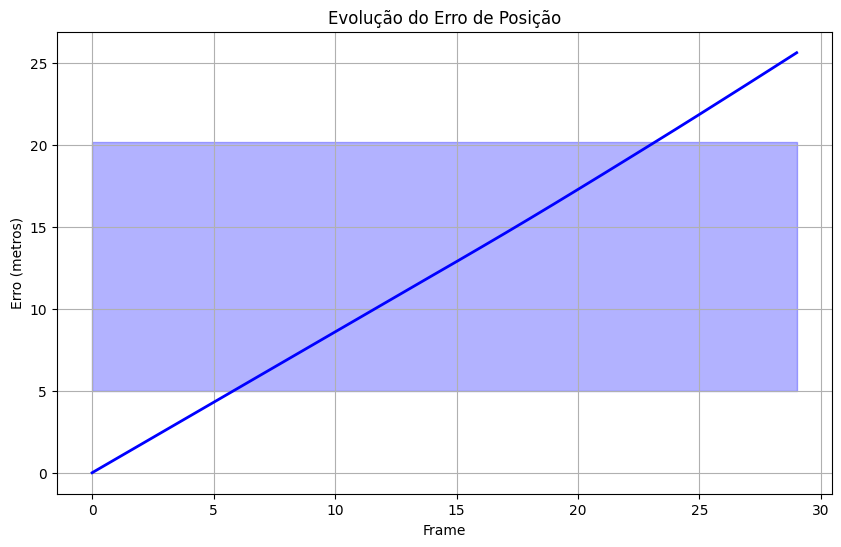

In [10]:
# Análise detalhada dos erros
erro_posicao = np.linalg.norm(xyz_est - xyz_gt, axis=1)
erro_x = np.abs(xyz_est[:,0] - xyz_gt[:,0])
erro_y = np.abs(xyz_est[:,1] - xyz_gt[:,1])
erro_z = np.abs(xyz_est[:,2] - xyz_gt[:,2])

print("=== ANÁLISE DE ERRO ===")
print(f"Erro médio total: {np.mean(erro_posicao):.3f} ± {np.std(erro_posicao):.3f} metros")
print(f"Erro X: {np.mean(erro_x):.3f} ± {np.std(erro_x):.3f} metros")
print(f"Erro Y: {np.mean(erro_y):.3f} ± {np.std(erro_y):.3f} metros")
print(f"Erro Z: {np.mean(erro_z):.3f} ± {np.std(erro_z):.3f} metros")
print(f"Erro máximo: {np.max(erro_posicao):.3f} metros")
print(f"Erro mínimo: {np.min(erro_posicao):.3f} metros")

# Plot da evolução do erro
plt.figure(figsize=(10, 6))
plt.plot(erro_posicao, 'b-', linewidth=2)
plt.fill_between(range(len(erro_posicao)), 
                 np.mean(erro_posicao) - np.std(erro_posicao),
                 np.mean(erro_posicao) + np.std(erro_posicao), 
                 alpha=0.3, color='blue')
plt.xlabel('Frame')
plt.ylabel('Erro (metros)')
plt.title('Evolução do Erro de Posição')
plt.grid(True)
plt.show()

In [9]:
def matriz_para_quaternion(R):
    """Converte matriz de rotação para quaternion"""
    trace = np.trace(R)
    if trace > 0:
        S = np.sqrt(trace + 1.0) * 2
        w = 0.25 * S
        x = (R[2,1] - R[1,2]) / S
        y = (R[0,2] - R[2,0]) / S
        z = (R[1,0] - R[0,1]) / S
    else:
        if R[0,0] > R[1,1] and R[0,0] > R[2,2]:
            S = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2
            w = (R[2,1] - R[1,2]) / S
            x = 0.25 * S
            y = (R[0,1] + R[1,0]) / S
            z = (R[0,2] + R[2,0]) / S
        elif R[1,1] > R[2,2]:
            S = np.sqrt(1.0 + R[1,1] - R[0,0] - R[2,2]) * 2
            w = (R[0,2] - R[2,0]) / S
            x = (R[0,1] + R[1,0]) / S
            y = 0.25 * S
            z = (R[1,2] + R[2,1]) / S
        else:
            S = np.sqrt(1.0 + R[2,2] - R[0,0] - R[1,1]) * 2
            w = (R[1,0] - R[0,1]) / S
            x = (R[0,2] + R[2,0]) / S
            y = (R[1,2] + R[2,1]) / S
            z = 0.25 * S
    return np.array([w, x, y, z])

# Extrair rotações
rotacoes_est = np.array([matriz_para_quaternion(traj[:3,:3]) for traj in trajetoria])
rotacoes_gt = np.array([matriz_para_quaternion(traj[:3,:3]) for traj in gt])

# Calcular erro de rotação (distância entre quaternions)
erro_rotacao = np.array([np.arccos(2 * np.dot(q1, q2)**2 - 1) for q1, q2 in zip(rotacoes_est, rotacoes_gt)])
erro_rotacao_graus = np.degrees(erro_rotacao)

print(f"Erro médio de rotação: {np.mean(erro_rotacao_graus):.2f}° ± {np.std(erro_rotacao_graus):.2f}°")

Erro médio de rotação: 0.02° ± 0.00°


In [8]:
# Instalar plotly para visualização 3D interativa
!pip install plotly

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Criar figura 3D interativa
fig = go.Figure()

# Trajetória estimada
fig.add_trace(go.Scatter3d(
    x=xyz_est[:,0], y=xyz_est[:,1], z=xyz_est[:,2],
    mode='lines+markers',
    name='Estimado (ICP)',
    line=dict(color='blue', width=4),
    marker=dict(size=3)
))

# Ground truth
fig.add_trace(go.Scatter3d(
    x=xyz_gt[:,0], y=xyz_gt[:,1], z=xyz_gt[:,2],
    mode='lines+markers',
    name='Ground Truth',
    line=dict(color='red', width=4),
    marker=dict(size=3)
))

fig.update_layout(
    title='Trajetória 3D Interativa - ICP vs Ground Truth',
    scene=dict(
        xaxis_title='X (metros)',
        yaxis_title='Y (metros)',
        zaxis_title='Z (metros)',
        aspectmode='data'
    ),
    width=800,
    height=600
)

fig.show()

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
